## Решение задачи регрессии с помощью нейронных сетей

Определение стоимости недвижимости из набора данных [California Housing Data Set](https://developers.google.com/machine-learning/crash-course/california-housing-data-description).

Учебный курс "[Программирование глубоких нейронных сетей на Python](https://openedu.ru/course/urfu/PYDNN/)".

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
""" посмотрим, какие файлы храняться в директории """
import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dl-urfu-regression/sample_submission.csv
/kaggle/input/dl-urfu-regression/train.csv
/kaggle/input/dl-urfu-regression/test.csv


## Загружаем данные

In [2]:
train_df = pd.read_csv('/kaggle/input/dl-urfu-regression/train.csv')
test_df = pd.read_csv('/kaggle/input/dl-urfu-regression/test.csv')
sample_submission = pd.read_csv('/kaggle/input/dl-urfu-regression/sample_submission.csv', index_col='id')

**Описание данных**

California Housing содержит данные о средней стоимость домов в Калифорнии для квартала. Файл с данными содержит следующие столбцы:

*   **longitude** - долгота квартала с недвижимостью.
*   **latitude** - широта квартала с недвижимостью.
*   **housing_median_age** - медиана возраста домов в квартале.
*   **total_rooms** - общее колиичество комнат в квартале.
*   **total_bedrooms** - общее количество спален в квартале.
*   **population** - население квартала.
*   **households** - количество "домохозяйств" в квартале (групп людей живущих вместе в одном доме. Как правило это семьи).
*   **median_income** - медианный доход в квартале.
*   **median_house_value** - медианная стоимость дома в квартале.



In [3]:
"""Смотрим на случайные 3 записи в нашем тренировочном наборе"""
train_df.sample(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
5592,-119.67,36.83,4.0,2145.0,334.0,1024.0,308.0,5.0864,113700.0
3712,-122.25,37.80,41.0,1471.0,469.0,1062.0,413.0,1.6121,171400.0
13920,-122.11,37.31,7.0,189.0,26.0,84.0,29.0,13.8093,500001.0


In [4]:
"""Смотрим на случайные 3 записи в нашем тестовом наборе"""
test_df.sample(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
788,-118.14,33.84,45.0,1908.0,361.0,890.0,342.0,4.5750
1736,-121.30,38.02,16.0,2717.0,621.0,3343.0,643.0,2.5473
2665,-122.09,37.38,34.0,1959.0,342.0,849.0,357.0,6.2884


In [5]:
"""Смотрим на случайные 3 записи в шаблоне для ответов"""
sample_submission.sample(3)

,median_house_value
id,
2767,0.2767
2191,0.2191
1461,0.1461


## Постановка задачи регрессии

Необходимо определить медианную стоимость дома в квартале, зная все остальные признаки.

**Целевая переменная**: `median_house_value`

**Признаки**: `longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households,	median_income`

Признаки подаются на вход нейронной сети, на выходе сеть должна выдать значение целевой переменной - `median_house_value`

In [6]:
"""Выделяем данные для обучения и преобразуем их в массивы numpy.
Функция pop() возвращает нам указанный столбец и одновременно удаляет его из таблицы.
Таким образом, когда мы присваиваем df_train в переменную x_train,
там уже нет столбца с метками правильных ответов median_house_value """
y_train = train_df.pop('median_house_value').values
x_train = train_df.values
x_test = test_df.values

In [7]:
"""Убедимся, что количество столбцов в данных совпадает"""
x_train.shape, x_test.shape

((17000, 8), (3000, 8))

**Стандартизация данных**

Вычитаем среднее значение и делим на стандартное отклонение

In [8]:
# Среднее значение
mean = x_train.mean(axis=0)
# Стандартное отклонение
std = x_train.std(axis=0)
x_train -= mean
x_train /= std
x_test -= mean
x_test /= std

## Создаем нейронную сеть

Выходной слой с одним линейным нейроном - для задачи регрессии функция активации - RELU.

In [9]:
model = Sequential([
    Dense(200, activation='relu', input_shape=(x_train.shape[1],)),
    Dropout(0.3),
    Dense(400, activation='relu'),
    Dropout(0.2),
    Dense(400, activation='relu'),
    Dropout(0.1),
    Dense(300, activation='relu'),
    Dense(200, activation='relu'),
    Dense(100, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1)
])

In [10]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               1800      
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 400)               160400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               1

**Компилируем сеть**

Функция ошибки - среднеквадратичное отклонение. Метрика - среднее абсолютное отклонение.

In [11]:
model.compile(optimizer='nadam', loss=tf.keras.losses.MeanAbsoluteError(), metrics=['mae'])

## Обучаем нейронную сеть

In [12]:
history = model.fit(x_train, 
                    y_train,
                    batch_size=100,
                    epochs=300,
                    validation_split=0.1, 
                    verbose=2)

Epoch 1/300
153/153 - 4s - loss: 86836.3516 - mae: 86836.3516 - val_loss: 52279.2656 - val_mae: 52279.2656
Epoch 2/300
153/153 - 2s - loss: 50673.5391 - mae: 50673.5391 - val_loss: 45518.0195 - val_mae: 45518.0078
Epoch 3/300
153/153 - 2s - loss: 48219.8555 - mae: 48219.8555 - val_loss: 44048.8594 - val_mae: 44048.8594
Epoch 4/300
153/153 - 2s - loss: 47218.9297 - mae: 47218.9297 - val_loss: 43546.8086 - val_mae: 43546.8086
Epoch 5/300
153/153 - 2s - loss: 46370.0781 - mae: 46370.0781 - val_loss: 43188.8125 - val_mae: 43188.8125
Epoch 6/300
153/153 - 2s - loss: 45974.9180 - mae: 45974.9180 - val_loss: 42933.6992 - val_mae: 42933.6992
Epoch 7/300
153/153 - 2s - loss: 45398.1133 - mae: 45398.1133 - val_loss: 44297.6602 - val_mae: 44297.6602
Epoch 8/300
153/153 - 2s - loss: 44845.0703 - mae: 44845.0703 - val_loss: 43011.5625 - val_mae: 43011.5625
Epoch 9/300
153/153 - 2s - loss: 44392.2383 - mae: 44392.2383 - val_loss: 41599.0898 - val_mae: 41599.0898
Epoch 10/300
153/153 - 2s - loss: 440

## Визуализация качества обучения

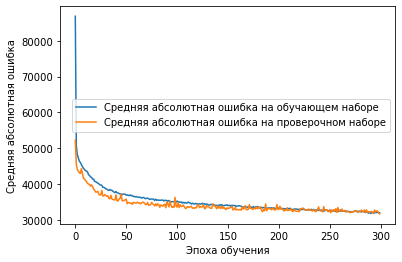

In [13]:
plt.plot(history.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

## Готовим данные для теста на liderboard

Делаем предсказания на тестовом наборе данных

In [14]:
"""делаем предсказания по всем тестовым данным"""
predictions = model.predict(x_test)
predictions

array([[ 59209.727],
       [ 68110.414],
       [ 65453.285],
       ...,
       [285989.28 ],
       [ 70272.37 ],
       [108070.61 ]], dtype=float32)

Пишем результаты предсказаний в шаблон "sample_submission"

In [15]:
"""используем файл с правильным шаблоном формата записи ответов и пишем в него наши предсказания"""
sample_submission['median_house_value'] = predictions

Записываем ответы для проверки на liderboard

In [16]:
"""to_csv - пишет табличные данные в файл '.csv' """
sample_submission.to_csv('sample_submission.csv')